In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np

In [2]:
class PatchDataset(Dataset):
    def __init__(self, original_dir, filtered_dir, patch_size=3):
        """
        original_dir: Orijinal resimlerin bulunduğu klasör (ör. 'imgs')
        filtered_dir: Filtrelenmiş resimlerin bulunduğu klasör (ör. 'filtered_imgs')
        patch_size: Kullanılacak patch boyutu (3x3 için 3)
        """
        self.original_dir = original_dir
        self.filtered_dir = filtered_dir
        self.patch_size = patch_size
        
        # Dosyaları isim sırasına göre alıyoruz (jpeg/jpg ve png uzantıları için)
        self.original_files = sorted([os.path.join(original_dir, f) for f in os.listdir(original_dir)
                                        if f.lower().endswith(('.jpg', '.jpeg'))])
        self.filtered_files = sorted([os.path.join(filtered_dir, f) for f in os.listdir(filtered_dir)
                                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        assert len(self.original_files) == len(self.filtered_files), "Orijinal ve filtrelenmiş resim sayıları uyuşmuyor."
        
        # Her resim için patch çıkarılabilecek merkezi piksel konumlarını hesaplıyoruz
        self.patch_indices = []
        for i, orig_file in enumerate(self.original_files):
            img = cv2.imread(orig_file, cv2.IMREAD_GRAYSCALE)
            h, w = img.shape
            # Kenar pikselleri hariç bırakılıyor (3x3 patch için)
            for r in range(1, h - 1):
                for c in range(1, w - 1):
                    self.patch_indices.append((i, r, c))
    
    def __len__(self):
        return len(self.patch_indices)
    
    def __getitem__(self, idx):
        image_idx, r, c = self.patch_indices[idx]
        orig_path = self.original_files[image_idx]
        filt_path = self.filtered_files[image_idx]
        
        # Gri tonlamalı resimleri okuyun
        orig_img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
        filt_img = cv2.imread(filt_path, cv2.IMREAD_GRAYSCALE)
        
        # Piksel değerlerini [-1, +1] aralığına normalize edin
        orig_img = orig_img.astype(np.float32) / 127.5 - 1.0
        filt_img = filt_img.astype(np.float32) / 127.5 - 1.0
        
        half = self.patch_size // 2
        # 3x3 patch'i orijinal resimden çıkarın (merkez (r, c))
        patch = orig_img[r - half: r + half + 1, c - half: c + half + 1]
        patch = patch.flatten()  # 9 elemanlı vektör
        
        # Hedef: filtrelenmiş resimdeki aynı konumdaki merkezi piksel
        target = filt_img[r, c]
        
        # Torch tensorlerine dönüştürün
        patch_tensor = torch.from_numpy(patch).float()
        target_tensor = torch.tensor(target).float()
        
        return patch_tensor, target_tensor

In [3]:
# Dataset'i oluşturun
dataset = PatchDataset('imgs', 'filtered_imgs', patch_size=3)
print("Dataset örnek sayısı:", len(dataset))
sample_patch, sample_target = dataset[0]
print("Bir patch'in boyutu:", sample_patch.shape, "Hedef piksel değeri:", sample_target.item())


Dataset örnek sayısı: 158760
Bir patch'in boyutu: torch.Size([9]) Hedef piksel değeri: 0.2627451419830322


In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Kullanılan cihaz:", device)

Kullanılan cihaz: cuda


In [6]:
# Model tanımı: Feedforward ANN
class FFANN(nn.Module):
    def __init__(self):
        super(FFANN, self).__init__()
        self.fc1 = nn.Linear(9, 21)
        self.fc2 = nn.Linear(21, 17)
        self.fc3 = nn.Linear(17, 13)
        self.fc4 = nn.Linear(13, 9)
        self.fc5 = nn.Linear(9, 1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.tanh(self.fc5(x))
        return x

# Dataset'iniz zaten oluşturulduğuna göre DataLoader ile verileri gruplayın:
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Model, kayıp fonksiyonu ve optimizörü tanımlayın
model = FFANN().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [7]:
# Eğitim döngüsü
num_epochs = 6  # İhtiyaç duyduğunuz kadar epoch ile deneyebilirsiniz
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()         # Gradients'i sıfırla
        outputs = model(inputs)         # İleri besleme
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()                 # Geri yayılım
        optimizer.step()                # Ağırlıkları güncelle
        
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/100:.4f}")
            running_loss = 0.0

print("Eğitim tamamlandı!")

Epoch 1, Batch 100, Loss: 0.0853
Epoch 1, Batch 200, Loss: 0.0871
Epoch 1, Batch 300, Loss: 0.0847
Epoch 1, Batch 400, Loss: 0.0852
Epoch 1, Batch 500, Loss: 0.0835
Epoch 1, Batch 600, Loss: 0.0826
Epoch 2, Batch 100, Loss: 0.0859
Epoch 2, Batch 200, Loss: 0.0814
Epoch 2, Batch 300, Loss: 0.0826
Epoch 2, Batch 400, Loss: 0.0806
Epoch 2, Batch 500, Loss: 0.0811
Epoch 2, Batch 600, Loss: 0.0802
Epoch 3, Batch 100, Loss: 0.0795
Epoch 3, Batch 200, Loss: 0.0805
Epoch 3, Batch 300, Loss: 0.0781
Epoch 3, Batch 400, Loss: 0.0743
Epoch 3, Batch 500, Loss: 0.0762
Epoch 3, Batch 600, Loss: 0.0724
Epoch 4, Batch 100, Loss: 0.0710
Epoch 4, Batch 200, Loss: 0.0685
Epoch 4, Batch 300, Loss: 0.0691
Epoch 4, Batch 400, Loss: 0.0644
Epoch 4, Batch 500, Loss: 0.0625
Epoch 4, Batch 600, Loss: 0.0606
Epoch 5, Batch 100, Loss: 0.0565
Epoch 5, Batch 200, Loss: 0.0541
Epoch 5, Batch 300, Loss: 0.0530
Epoch 5, Batch 400, Loss: 0.0499
Epoch 5, Batch 500, Loss: 0.0486
Epoch 5, Batch 600, Loss: 0.0463
Epoch 6, B

ANN çıktısı kaydedildi: ann_output_img1.png


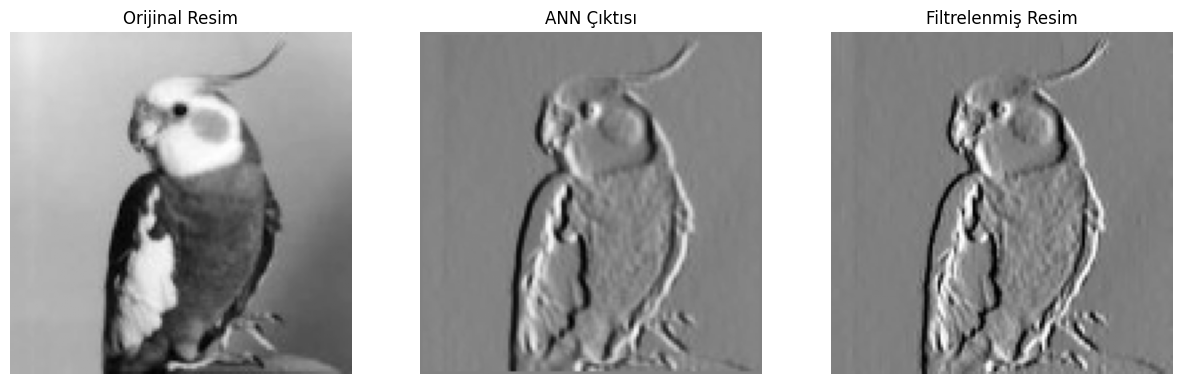

In [20]:
import matplotlib.pyplot as plt

# Test resmi ve karşılık gelen filtrelenmiş resim dosya yolları
img_path = "imgs/img1.jpeg"
filtered_path = "filtered_imgs/img1_filtered.png"

# Resimleri yükleyin (grayscale)
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
filtered_img = cv2.imread(filtered_path, cv2.IMREAD_GRAYSCALE)

# Resimlerin boyutunun 128x128 olduğunu varsayıyoruz
h, w = original_img.shape

# Resimleri normalize edin: 0-255 -> [-1, +1]
orig_norm = original_img.astype(np.float32) / 127.5 - 1.0

# Boş bir tahmin resmi oluşturun (sadece kenarlar hariç tahmin yapacağız)
predicted = np.zeros_like(orig_norm)

# Modeli değerlendirme moduna alın
model.eval()

with torch.no_grad():
    # Kenarlar hariç (1'den h-1'e, 1'den w-1'e) tüm pikseller için tahmin yapın
    for r in range(1, h - 1):
        for c in range(1, w - 1):
            # 3x3 patch çıkarın
            patch = orig_norm[r - 1:r + 2, c - 1:c + 2]
            patch = patch.flatten()
            patch_tensor = torch.from_numpy(patch).float().unsqueeze(0).to(device)
            output = model(patch_tensor)
            predicted[r, c] = output.item()

# Tahmin edilen resmi [-1, 1]'den 0-255 ölçeğine geri dönüştürün
predicted_denorm = ((predicted + 1.0) * 127.5).astype(np.uint8)

ann_output_path = "ann_output_img1.png"
cv2.imwrite(ann_output_path, predicted_denorm)
print(f"ANN çıktısı kaydedildi: {ann_output_path}")

# Sonuçları yan yana görselleştirin
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Orijinal Resim")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(predicted_denorm, cmap="gray")
plt.title("ANN Çıktısı")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(filtered_img, cmap="gray")
plt.title("Filtrelenmiş Resim")
plt.axis("off")

plt.show()


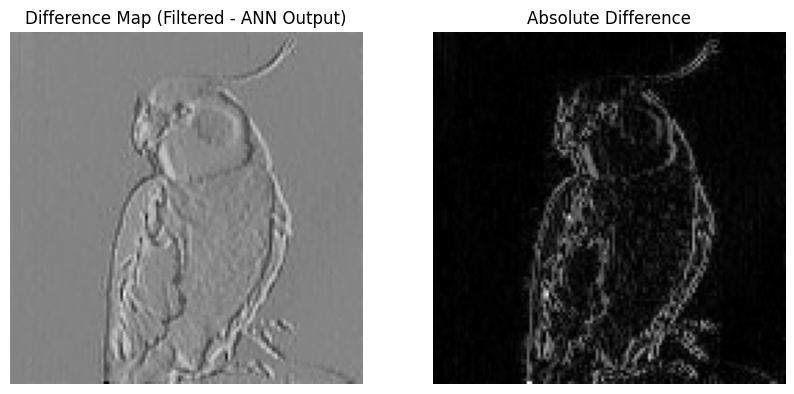

In [14]:
# 'predicted_denorm' = ANN çıktısı (0-255 aralığında, uint8)
# 'filtered_img'     = Gerçek filtrelenmiş görüntü (0-255 aralığında, uint8)

# Float'a çevirin
predicted_float = predicted_denorm.astype(np.float32)
filtered_float = filtered_img.astype(np.float32)

# Fark haritası (filtered - ANN_output)
difference_map = filtered_float - predicted_float

# İsteğe bağlı: Görselleştirme
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(difference_map, cmap='gray')
plt.title("Difference Map (Filtered - ANN Output)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.abs(difference_map), cmap='gray')
plt.title("Absolute Difference")
plt.axis('off')
plt.show()

In [15]:
from sklearn.neighbors import NearestNeighbors

class DiffPatchTable:
    def __init__(self, diff_map, patch_size=5):
        """
        diff_map: Fark haritası (filtered_img - ann_output), float32 veya benzeri.
        patch_size: Yama boyutu (5x5, 7x7 vb.)
        """
        self.patch_size = patch_size
        self.h, self.w = diff_map.shape
        half = patch_size // 2
        
        patches = []
        # Patch'leri kaydetmek için (row, col, patch_vector) şeklinde bir liste tutabiliriz.
        positions = []
        
        for r in range(half, self.h - half):
            for c in range(half, self.w - half):
                patch = diff_map[r - half:r + half + 1, c - half:c + half + 1]
                patch_flat = patch.flatten()
                patches.append(patch_flat)
                positions.append((r, c))
        
        # NumPy dizisine dönüştür
        self.patches = np.array(patches)  # (N, patch_size*patch_size)
        self.positions = positions
        
        # k-NN için model oluşturuyoruz (örnek: en yakın 1 komşu)
        self.nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto')
        self.nn_model.fit(self.patches)
    
    def find_best_patch(self, query_patch):
        """
        query_patch: Yeni bir konumdaki diff patch (vektör).
        Dönen: (best_patch, best_position)
        """
        distances, indices = self.nn_model.kneighbors([query_patch], n_neighbors=1)
        best_idx = indices[0, 0]
        return self.patches[best_idx], self.positions[best_idx]


In [16]:
def apply_style_with_knn(original_img, ann_output, diff_patch_table, patch_size=5):
    """
    original_img: Orijinal (ya da ANN çıktı) resmi float32 olarak (0..255) veya [-1..1]
    ann_output: ANN çıktısı (aynı boyutta)
    diff_patch_table: Daha önce oluşturduğumuz DiffPatchTable örneği
    patch_size: Yama boyutu
    """
    h, w = original_img.shape
    half = patch_size // 2
    
    # Final resim
    final_stylized = ann_output.copy().astype(np.float32)
    
    for r in range(half, h - half):
        for c in range(half, w - half):
            # Burada basitçe, ANN çıktısı ile benzer bir patch aradığımızı varsayalım.
            # Aslında makalede "difference" patch aranıyor.
            # Kolaylık olsun diye ann_output patch'i üzerinden k-NN yapıyoruz.
            patch = ann_output[r - half:r + half + 1, c - half:c + half + 1]
            patch_flat = patch.flatten()
            
            # k-NN'de en yakın fark patch'ini bul
            best_diff_patch, _ = diff_patch_table.find_best_patch(patch_flat)
            best_diff_patch = best_diff_patch.reshape(patch_size, patch_size)
            
            # Mevcut konumdaki pikselleri güncelle
            # (Makaledeki formül: B'(x,y) = B"(x,y) + T(x,y))
            final_stylized[r, c] += best_diff_patch[half, half]
    
    # Değerleri 0..255 aralığına çek
    final_stylized = np.clip(final_stylized, 0, 255).astype(np.uint8)
    return final_stylized


In [21]:
# 1) Eğitim (veya herhangi bir) resim çifti: orijinal & filtrelenmiş
filtered_img_path = "filtered_imgs/img1_filtered.png"  # Gerçek filtrelenmiş resim
ann_output_path   = "ann_output_img1.png"     # ANN'in çıkardığı sonuç

# 2) Resimleri yükleyin
filtered_img = cv2.imread(filtered_img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
ann_output  = cv2.imread(ann_output_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

# 3) Difference map hesaplayın
diff_map = filtered_img - ann_output

# 4) Patch tablosu oluşturun (patch_size=5 veya 7 vb. seçebilirsiniz)
diff_table = DiffPatchTable(diff_map, patch_size=5)

In [24]:
# Orijinal test görüntüsü (gri tonlamalı)
test_img_path = "imgs/img1.jpeg"
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

# Test resmi için ANN çıktısını (B") alınmış varsayalım (dosyadan yükleme veya anlık tahmin):
ann_output_test_path = "ann_output_img1.png"
ann_output_test = cv2.imread(ann_output_test_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)


Doku sentezi tamamlandı, sonuç kaydedildi.


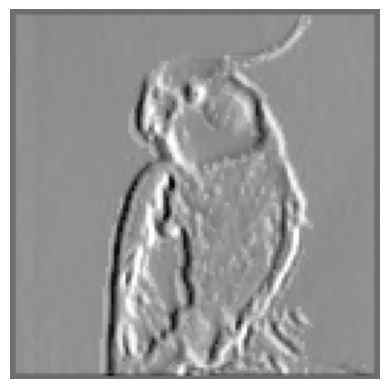

In [26]:
# Doku sentezini uygula
final_stylized = apply_style_with_knn(
    original_img=test_img,          # Test resmi (float32)
    ann_output=ann_output_test,     # ANN çıktısı (float32)
    diff_patch_table=diff_table,    # Bir önceki adımda oluşturulan tablo
    patch_size=5
)

# Sonucu kaydedin veya görselleştirin
cv2.imwrite("final_stylized_img1.png", final_stylized)
print("Doku sentezi tamamlandı, sonuç kaydedildi.")
plt.imshow(final_stylized, cmap='gray')
plt.axis('off')
plt.show()